## Preparing

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import nltk
nltk.download('gutenberg')
nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt')

import os
ROOTDIR = os.path.abspath(os.path.dirname('__file__'))
DATADIR = os.path.join(ROOTDIR, 'data')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Doc2Vec

### 1 Preprocessing
Clean the data by removing stopwords and punctuations, lower-case. 

In [0]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
import re
import string

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FakeNewsTutorials/HW2-Group 1-Binkai Tan/data/movie_reviews.csv')
# data = shuffle(data, random_state=42)

text = data['text'].apply(cleanup)
sentences = constructLabeledSentences(text)
text.head()
y = data.label.values



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  # Remove the CWD from sys.path while we load stuff.


In [0]:
sentences[0]

LabeledSentence(words=['entire', 'generation', 'filmgoers', 'might', 'represent', 'significant', 'leap', 'storytelling', 'ever', 'see'], tags=['Text_0'])

### 2 Text Featurizer using Doc2Vec

In [0]:
from gensim.models import Doc2Vec

Text_INPUT_DIM = 50  # set the size of each vector is 50
text_model = Doc2Vec(min_count=1, window=5, size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
text_model.build_vocab(sentences)
text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [0]:
X = np.zeros((data.shape[0], Text_INPUT_DIM))
i = 0
for i in range(data.shape[0]):
 X[i] = text_model.docvecs[i]

X[0]  # show the first text's vector

array([-0.00467623,  0.00365621, -0.00480825, -0.01905784, -0.00134887,
       -0.0072722 , -0.00697678,  0.01978192,  0.00975601,  0.02928802,
        0.01240059,  0.00696756, -0.01121603, -0.00165503,  0.00762727,
       -0.00982815,  0.00956465,  0.01157365,  0.00928226,  0.00149612,
       -0.00593742,  0.02258207, -0.00318243,  0.01660633, -0.02208379,
       -0.00923736, -0.00186733, -0.01562541, -0.00134578, -0.00742968,
        0.00303014,  0.0155102 , -0.00180813,  0.01466939,  0.00809295,
        0.00870799,  0.02648884,  0.00969607,  0.00706814, -0.00934947,
       -0.00789234,  0.01405114, -0.01968639,  0.0131123 , -0.00104615,
        0.00439723,  0.00391086, -0.00352206,  0.00379261,  0.0046856 ])

### 3 Split data

In [0]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(X)
y = pd.DataFrame(y)
# X.columns = ['x'+str(i) for i in range(1, Text_INPUT_DIM+1)]
y.columns = ['label']
# split X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
101024,0.015390,-0.014580,-0.000754,-0.003510,-0.006427,0.001476,-0.025559,0.008205,0.019488,-0.004413,0.000982,0.011088,0.001217,0.015305,-0.010581,-0.007345,0.010402,-0.009501,-0.008682,-0.004521,0.000889,-0.003016,0.004016,-0.022265,0.003010,-0.000843,-0.013279,-0.015544,-0.022274,-0.014582,0.012438,-0.018960,0.011114,0.007596,0.009924,-0.017522,-0.004930,0.004228,-0.007762,-0.018316,-0.016540,0.001049,-0.001393,0.008255,0.004418,-0.006763,-0.000861,-0.003697,-0.007788,0.010636
28169,0.015217,-0.004652,-0.011362,-0.018240,0.004522,-0.000022,-0.002469,-0.012450,-0.013378,0.004731,0.002208,-0.012156,0.019445,0.009510,0.017281,-0.001013,0.009243,0.026722,-0.012644,0.017119,-0.008879,-0.010322,-0.009388,0.000394,-0.007870,0.007446,0.001883,-0.017057,-0.025080,-0.020942,0.019762,-0.002678,0.012568,-0.002636,-0.001398,0.010500,0.003812,0.005335,-0.008388,0.016437,-0.005669,0.008737,-0.010580,0.007495,-0.009751,0.014271,0.002629,0.001646,0.000882,0.004998
18071,0.000248,-0.010060,-0.020780,-0.018629,-0.009305,-0.002863,0.014816,-0.004328,-0.013444,0.005614,0.015566,0.035796,-0.003717,-0.003513,0.014701,-0.005389,0.009024,0.016953,-0.006113,-0.011070,0.010744,0.024221,0.012756,0.005841,-0.020523,-0.004794,0.000904,0.004879,0.033170,-0.011940,0.007388,0.015177,-0.010559,0.029635,-0.000899,0.011677,0.036664,-0.005582,0.030664,0.004018,-0.004355,0.009528,-0.013535,-0.046576,-0.015581,-0.011856,0.027317,-0.006953,-0.001874,-0.017374
85958,-0.005634,-0.002457,0.012627,0.004909,0.021296,-0.011695,-0.005882,-0.044106,-0.010120,-0.038461,-0.030502,0.013305,-0.010055,0.009699,0.004959,0.029361,-0.020749,-0.018170,0.025280,-0.029996,0.017214,-0.010278,-0.008164,-0.031146,0.003414,0.002179,0.023038,0.008796,-0.014566,-0.009819,0.022752,0.009761,-0.030573,-0.003412,0.016242,0.000248,0.024405,0.007522,-0.008920,0.047434,0.008332,-0.012586,0.006488,0.003709,0.028778,-0.020362,-0.050755,0.012426,-0.000861,0.008590
11855,-0.020952,-0.008386,0.002231,0.014776,0.005303,0.007027,-0.021853,-0.009716,-0.001236,-0.003700,-0.013777,0.003678,-0.013424,0.007443,0.007139,-0.001766,0.001384,-0.009979,0.005536,0.002608,0.003559,0.002370,-0.000902,-0.004669,0.002820,-0.001676,0.002727,0.005803,-0.007985,-0.007268,-0.004262,0.005261,0.002571,0.003973,0.007291,0.016532,0.015124,-0.004211,0.000108,0.010632,0.000220,-0.018444,0.013121,0.014588,-0.007765,-0.008396,-0.014024,0.001360,0.005245,0.004756


In [0]:
y_train.head()

,label
101024,1
28169,0
18071,0
85958,0
11855,1


### 4 Training model and predict
Use XGBoost to train the model.

In [0]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train.values.ravel())
pred = xgb_model.predict(X_test)


# rf_model = RandomForestClassifier()
# rf_model.fit(X_train, y_train.values.ravel())  # Fit XGB classifier according to X, y
# pred = rf_model.predict(X_test)  # Perform classification on an array of test vectors X.
print(pred)

[1 1 1 ... 1 1 0]


### 5 Evaluating

In [0]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, make_scorer
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# confusion matrix, precision, recall, f1
cm = metrics.confusion_matrix(y_test, pred)
print("confusion matrix: ")
print(cm)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)
print("precision:   %0.3f" % precision)
print("recall:   %0.3f" % recall)
print("f1:   %0.3f" % f1)

confusion matrix: 
[[ 4358  8189]
 [ 2745 15230]]
precision:   0.650
recall:   0.847
f1:   0.736


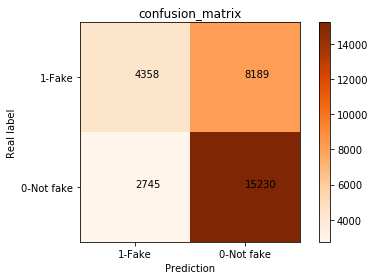

In [0]:
# plot the confusion matrix
classes = ['1-Fake', '0-Not fake']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)  # Display matrix by pixel
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

iters = np.reshape([[[i, j] for j in range(2)] for i in range(2)], (cm.size, 2))
for i, j in iters:
    plt.text(j, i, format(cm[i, j]))  # Display the corresponding number

plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
plt.show()

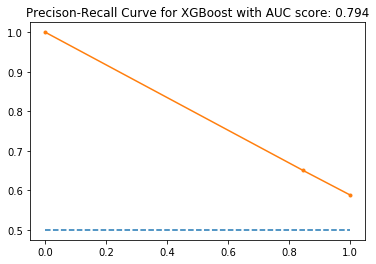

In [0]:
# plot the precision-recall curve for XGBoostwith AUC
from sklearn.metrics import auc
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# calculate precision-recall AUC
auc_xgb = auc(recall, precision)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.title("Precison-Recall Curve for XGBoost with AUC score: {:.3f}".format(auc_xgb))
# show the plot
plt.show()

## Word2Vec

### 1 Preprocessing
Clean the data by removing stopwords and punctuations, lower-case. 

In [28]:
from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
import re
import string

# Create an iterator object that returns words properly formatted for Word2Vec training
class NewsIterator:
    def __init__(self, dataset):
        self.dataset = dataset

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for news in self.dataset.iloc[:, 1]:
            # Make all characters lower-case
            news = news.lower()
            for sentence in news.split('.')[:-1]:
                # Clean string of all punctuation
                sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FakeNewsTutorials/HW2-Group 1-Binkai Tan/data/movie_reviews.csv')

sentences = NewsIterator(data)
y = data.label.values
sentences



### 2 Text Featurizer using Word2Vec

Train the word2vec

In [0]:
from gensim import models

# Train Word2Vec model with gensim on the dataset
w2v_model = models.Word2Vec(sentences, size=100, window=5, min_count=1, workers=8)

check it (some words' similarity)

In [33]:
# Retrieve the weights from the model. This is used for initializing the weights
# in a Keras Embedding layer later
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

# Some validation on the quality of the Word2Vec model
print(w2v_model.wv.most_similar('1', topn=3))
print(w2v_model.wv.most_similar('still', topn=3))
print(w2v_model.wv.most_similar(positive=['rei', 'mulher'], negative=['homem'], topn=3))

def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

Vocabulary Size: 181188 - Embedding Dim: 100
[('4', 0.7758281230926514), ('7', 0.7724025249481201), ('9', 0.7693166732788086)]
[('certainly', 0.6747924089431763), ('also', 0.6208809614181519), ('always', 0.5943617820739746)]
[('swineherder', 0.5573649406433105), ('puivert', 0.4924606382846832), ('ferrailleurs', 0.4906444251537323)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Visualizing Word2Vec Embeddings with t-SNE

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


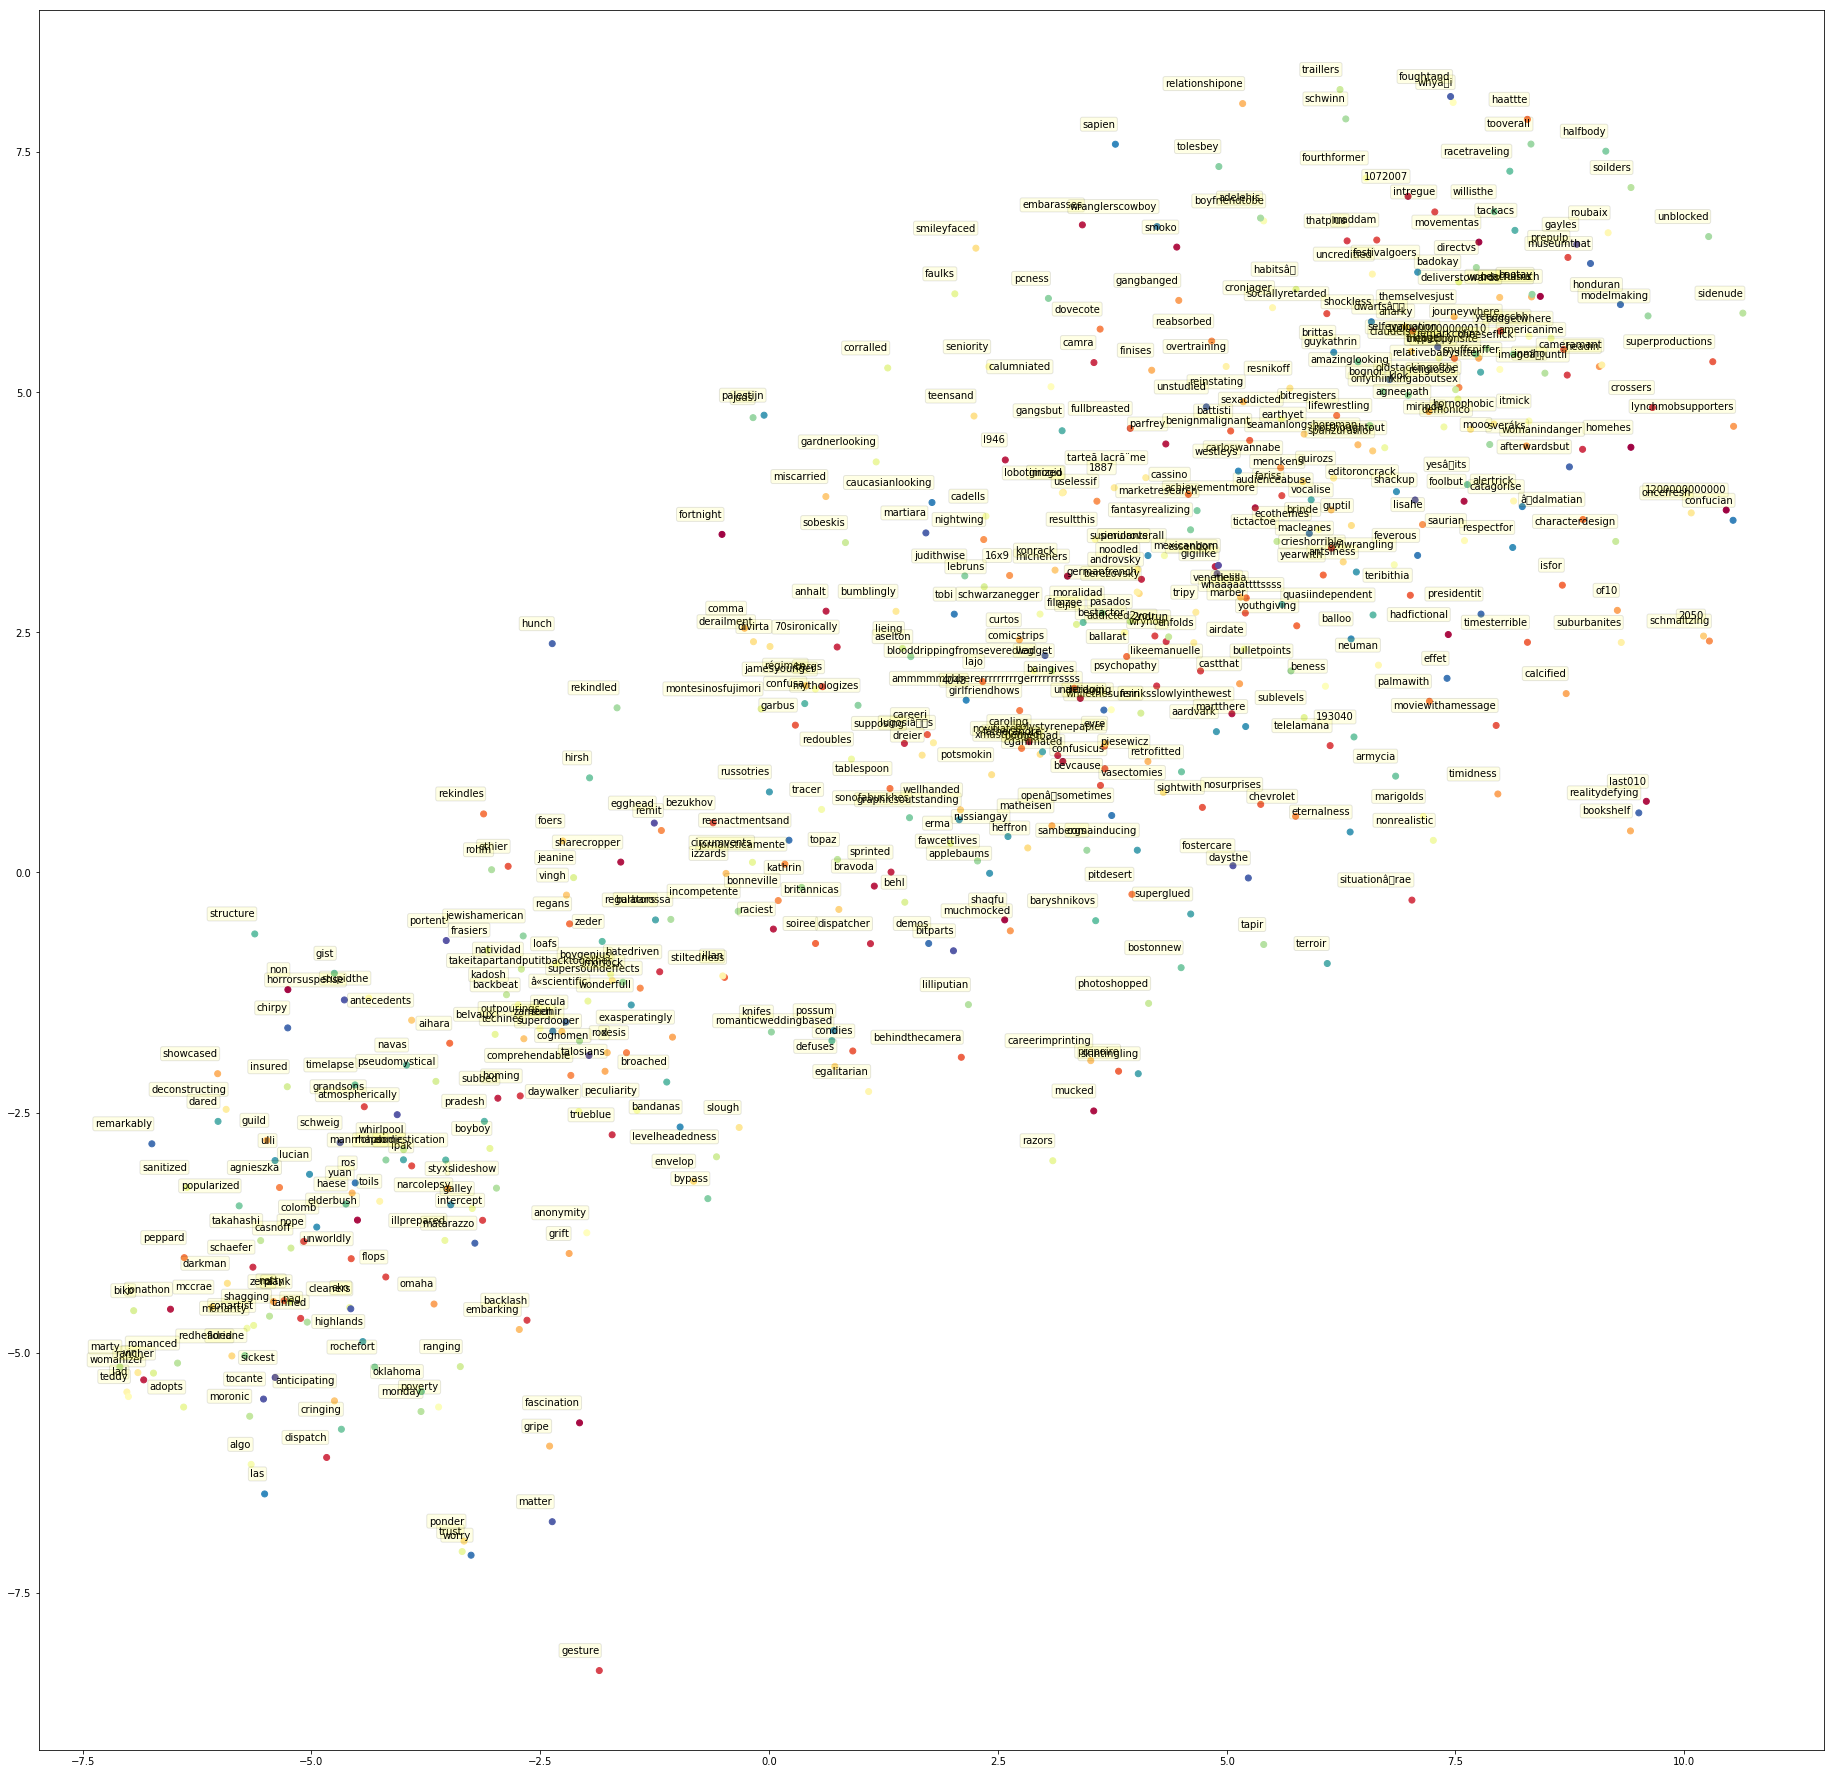

In [36]:
from sklearn.manifold import TSNE
import random 
import matplotlib.pyplot as plt

n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([w2v_model[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

In [43]:
from keras.preprocessing.sequence import pad_sequences

# Create an iterator that formats data from the dataset proper for
# LSTM training

# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 200

# Samples of label with less than this number of samples will be ignored
DROP_THRESHOLD = 10000

class SequenceIterator:
    def __init__(self, dataset, drop_threshold, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.label, self.ccount = np.unique(dataset.label, return_counts=True)
        
        self.seq_length = seq_length
        
        # Samples of label with less than this number of samples will be ignored
        self.drop_categos = []
        for cat, count in zip(self.label, self.ccount):
            if count < drop_threshold:
                self.drop_categos.append(cat)
        
        # Remaining label
        self.label = np.setdiff1d(self.label, self.drop_categos)
        
    def __iter__(self):
        for news, cat in zip(self.dataset.iloc[:, 1], self.dataset.iloc[:, 0]):
            if cat in self.drop_categos:
                continue
            
            # Make all characters lower-case
            news = news.lower()
            
            # Clean string of all punctuation
            news = news.translate(self.translator)

            words = np.array([word2token(w) for w in news.split(' ')[:self.seq_length] if w != ''])
                                
            yield (words, cat)

sequences = SequenceIterator(data, DROP_THRESHOLD, MAX_SEQUENCE_LENGTH)

# Used for generating the labels in the set
cat_dict = {k: v for k, v in zip(sequences.label, range(len(sequences.label)))}

set_x = []
set_y = []
for w, c in sequences:
    set_x.append(w)
    set_y.append(cat_dict[c])
    
# Padding sequences with 0.
X = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
y = np.array(set_y)

print(X.shape)
print(y.shape)

(152610, 200)
(152610,)


### 3 Split data

In [0]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(X)
y = pd.DataFrame(y)
# X.columns = ['x'+str(i) for i in range(1, Text_INPUT_DIM+1)]
y.columns = ['label']
# split X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
101024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,136,1090,17,37,0,14255,3,1771,2,0,1384,3,6096,5451,30,180,0,190,2,0,172
28169,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,349,2358,37,0,351,3060,26522,1,77,235,782,12,7,2,9161,22,15367,78,125,7
18071,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,5,269,4380,149,32,155,224,19,1449,3,0,744,5,956,1693
85958,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,31,89,191,2,89,6829,10607,6,1,28990,1221,10,144,26,4148,852,99,154
11855,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3634,10918


In [46]:
y_train.head()

,label
101024,1
28169,0
18071,0
85958,0
11855,1


### 4 Training model and predict
Use XGBoost to train the model.

In [47]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train.values.ravel())
pred = xgb_model.predict(X_test)


# rf_model = RandomForestClassifier()
# rf_model.fit(X_train, y_train.values.ravel())  # Fit XGB classifier according to X, y
# pred = rf_model.predict(X_test)  # Perform classification on an array of test vectors X.
print(pred)

[1 1 1 ... 1 1 1]


### 5 Evaluating

In [48]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, make_scorer
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# confusion matrix, precision, recall, f1
cm = metrics.confusion_matrix(y_test, pred)
print("confusion matrix: ")
print(cm)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)
print("precision:   %0.3f" % precision)
print("recall:   %0.3f" % recall)
print("f1:   %0.3f" % f1)

confusion matrix: 
[[ 3556  8991]
 [ 2344 15631]]
precision:   0.635
recall:   0.870
f1:   0.734


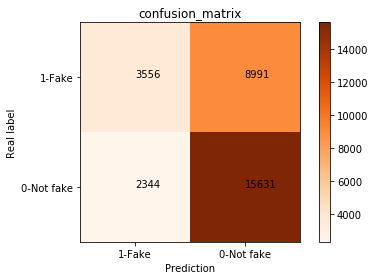

In [49]:
# plot the confusion matrix
classes = ['1-Fake', '0-Not fake']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)  # Display matrix by pixel
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

iters = np.reshape([[[i, j] for j in range(2)] for i in range(2)], (cm.size, 2))
for i, j in iters:
    plt.text(j, i, format(cm[i, j]))  # Display the corresponding number

plt.ylabel('Real label')
plt.xlabel('Prediction')
plt.tight_layout()
plt.show()

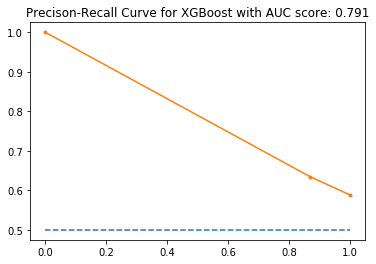

In [50]:
# plot the precision-recall curve for XGBoostwith AUC
from sklearn.metrics import auc
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, pred)
# calculate precision-recall AUC
auc_xgb = auc(recall, precision)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.title("Precison-Recall Curve for XGBoost with AUC score: {:.3f}".format(auc_xgb))
# show the plot
plt.show()

## TF-IDF

### 1 Loading data

In [0]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FakeNewsTutorials/HW2-Group 1-Binkai Tan/data/movie_reviews.csv')
# data = shuffle(data, random_state=42)

texts = data.text.values #pd.Series -> np.ndarray
y = data.label.values

In [0]:
import nltk
# Transform each review string as a list of token strings. May take a few seconds
tokenized = [nltk.word_tokenize(review) for review in texts]

In [6]:
n = 10 #arbitrary pick
print('Example review:\n   Raw: {} \n\n   Tokenized: {}'.format(texts[n], [i for i in tokenized[n]]))

Example review:
   Raw: So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm. 

   Tokenized: ['So', 'ingenious', 'in', 'concept', ',', 'design', 'and', 'execution', 'that', 'you', 'could', 'watch', 'it', 'on', 'a', 'postage', 'stamp-sized', 'screen', 'and', 'still', 'be', 'engulfed', 'by', 'its', 'charm', '.']


### 2 Cleaning text data

#### 2.1 Removing Stopwords and Punctuations, Lower-case

In [7]:
from collections import Counter

#Note that we convert all tokens to lower case, otherwise words like *The* and *the* are different tokens.
token_counter = Counter(token.lower() for sentence in tokenized for token in sentence)
top10 = token_counter.most_common()[:10]
for i, t in enumerate(top10):
    print('{:>2}.{:>5}  freq: {:>7}'.format(i+1, t[0], t[1]))

 1.  the  freq:  748991
 2.    ,  freq:  643961
 3.    .  freq:  573700
 4.    a  freq:  388642
 5.  and  freq:  380566
 6.   of  freq:  347832
 7.   to  freq:  303863
 8.   is  freq:  251627
 9.   ''  freq:  229572
10.   it  freq:  216880


#### 2.2 Stemming and Lemmatizing

In [0]:
from nltk.corpus import stopwords
from string import punctuation
from itertools import chain

def clean_text(tokenized_list, sw, punct, lemmatize=False):
    new_list = []
    for doc in tokenized_list:
        new_list.append([token.lower() for token in doc if token.lower() not in chain(punct, sw)])
    return new_list

# Remove punctuations and stopwords, and lower-case text
sw = stopwords.words('english')
punct = punctuation
cleaned = clean_text(tokenized, sw, punct)

In [0]:
from gensim import corpora

# Create a dictionary from list of documents in order to create BOW model
dictionary = corpora.Dictionary(cleaned)

### 3 TF-IDF

In [10]:
from gensim import corpora, models

#Create a TFIDF Model for the corpus
corpus = [dictionary.doc2bow(text) for text in cleaned]
tfidf = models.TfidfModel(corpus)

print('Example review featurized with TF-IDF scores : \n{}'.format([(dictionary[i[0]], round(i[1],3)) for i in tfidf[corpus[n]]]))

Example review featurized with TF-IDF scores : 
[('still', 0.117), ('charm', 0.211), ('concept', 0.217), ('could', 0.101), ('design', 0.236), ('engulfed', 0.371), ('execution', 0.252), ('ingenious', 0.296), ('postage', 0.478), ('screen', 0.15), ('stamp-sized', 0.526), ('watch', 0.114)]


Due to the TF-IDF is a high dimension method to train the model, it needs too long time to fit it. So we stop at here now.